In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

import os

In [2]:
# create adjacency matrix for network A
index_i_A, index_j_A = np.loadtxt("net1.txt", dtype=np.int, unpack=True)
dim = max(index_i_A.max(), index_j_A.max())+1
NetA_matrix = np.zeros((dim, dim))
for i,j in zip(index_i_A, index_j_A):
    # the adjacency matrix needs to be symmetric
    NetA_matrix[i, j] = 1
    NetA_matrix[j, i] = 1

# create adjacency matrix for network B
index_i_B, index_j_B = np.loadtxt("net2.txt", dtype=np.int16, unpack=True)
dim = max(index_i_B.max(), index_j_B.max())+1
NetB_matrix = np.zeros((dim, dim))
for i,j in zip(index_i_B, index_j_B):
    # the adjacency matrix needs to be symmetric
    NetB_matrix[i, j] = 1
    NetB_matrix[j, i] = 1
    
NetA = nx.from_numpy_array(NetA_matrix)
NetB = nx.from_numpy_array(NetB_matrix)

In [3]:
np.random.seed(20190410)

In [14]:
def Gillespie(net, netName="test", lambdas=np.linspace(0.05,1, 50), mu=0.5, infects=50, n_steps=3000, N_rep=100):
    netmat = nx.to_numpy_matrix(net)
    net = nx.from_numpy_array(netmat)
    dim = net.number_of_nodes()
    # get edge list (two arrays: index_i--index_j)
    ed_list = nx.generate_edgelist(net, data=False) ########MODIFICATO
    index_i, index_j = [], []
    for line in ed_list:
        index_i.append(int(line.split()[0]))
        index_j.append(int(line.split()[1]))
    index_i = np.array(index_i)
    index_j = np.array(index_j)
    
    lambda_mean_list=[]
    lambda_std_list=[]

    for number,l in enumerate(lambdas):
        print("***lambda =", l)
        iter_matrix=[]
        for repetition in range(N_rep):

            state = np.zeros(dim)
            # put Infected in the network
            state[np.random.choice(dim, infects, replace=False)] = 1
            I_number = [infects]

            link_matrix = np.zeros((dim,dim))
            for i,j in zip(index_i, index_j):
                if state[i] == state[j]:
                    link_matrix[i,j] = 0
                    link_matrix[j,i] = 0
                else:
                    link_matrix[i,j] = 1
                    link_matrix[j,i] = 1

            for steps in range(n_steps):
                n_I = state.sum() # #Infected
                n_S = dim - n_I   # #Susceptible
                n_N = dim
                link_sum = 0.5*link_matrix.sum()
                a1  = mu*n_I
                a2  = l*link_sum#l*n_I*n_S/N_n
                a0  = a1+a2
                p_a1= a1/a0
                # select the reaction
                # reaction 1
                if np.random.rand() < p_a1:
                    # select I at random
                    I_index    = np.where(state == 1)[0]
                    I_selected = np.random.choice(I_index)
                    #print("I_selected =", I_selected)
                    # I -> S
                    state[I_selected] = 0
                    neighbours = np.array([n for n in net.neighbors(I_selected)])
                    for Nn in neighbours:
                        if state[I_selected] == state[Nn]:
                            link_matrix[I_selected,Nn] = 0
                            link_matrix[Nn,I_selected] = 0
                        else:
                            link_matrix[I_selected,Nn] = 1
                            link_matrix[Nn,I_selected] = 1

                # reaction 2
                else:
                    # select I at random
                    I_index = np.where(state == 1)[0]
                    np.random.shuffle(I_index)

                    for k in I_index:
                        # get list of neighbours
                        neighbours = np.array([n for n in net.neighbors(k)])
                        # if the node is isolated, search for another one
                        if len(neighbours) == 0: continue
                        nn_infected = state[neighbours].sum()
                        if nn_infected == len(neighbours): 
                            continue
                        else:
                            np.random.shuffle(neighbours)
                            for NNs in neighbours:
                                if state[NNs] == 0:
                                    state[NNs] = 1

                                    NNNeighbours = np.array([n for n in net.neighbors(NNs)])
                                    for VIC in NNNeighbours:
                                        if state[NNs] == state[VIC]:
                                            link_matrix[NNs,VIC] = 0
                                            link_matrix[VIC,NNs] = 0
                                        else:
                                            link_matrix[NNs,VIC] = 1
                                            link_matrix[VIC,NNs] = 1
                                    break
                            break
                I_number.append(state.sum())  
            iter_matrix.append(I_number)
        filename = netName+"/iterations/"+str(number)+".gz"
        iter_matrix = np.array(iter_matrix)
        np.savetxt(filename, iter_matrix)
        lambda_mean_list.append(iter_matrix.mean(axis=0))
        lambda_std_list.append(iter_matrix.std(axis=0))
    np.savetxt(netName+"/mean.gz", np.array(lambda_mean_list))
    np.savetxt(netName+"/std.gz", np.array(lambda_std_list))
    return lambda_mean_list, lambda_std_list

In [12]:
# Network A
net_list = [NetA]

NetA_copy = NetA.copy()

for i in range(10):
    node_deg = NetA_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetA_copy.remove_node(np.argmax(Net_degree))
    
net_list.append(NetA_copy)

NetA_copy = NetA.copy()

for i in range(10):
    node_bet = list(nx.betweenness_centrality(NetA_copy).values())
    NetA_copy.remove_node(np.argmax(node_bet))
    
net_list.append(NetA_copy)

NetA_copy = NetA.copy()

for i in range(5):
    node_deg = NetA_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetA_copy.remove_node(np.argmax(Net_degree))
for i in range(5):
    node_bet = list(nx.betweenness_centrality(NetA_copy).values())
    NetA_copy.remove_node(np.argmax(node_bet))

net_list.append(NetA_copy)

net_list_name = ["NetA", "NetA_rm10deg", "NetA_rm10bet", "NetA_rm5deg5bet"]   ####MODIFICATO


"""for n,name in zip(net_list, net_list_name):
    os.makedirs(name+"/iterations/")
    Gillespie(net=n, netName=name)"""

'for n,name in zip(net_list, net_list_name):\n    os.makedirs(name+"/iterations/")\n    Gillespie(net=n, netName=name)'

*** Network: NetA ***
isConnected = True
# connected components = 1


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


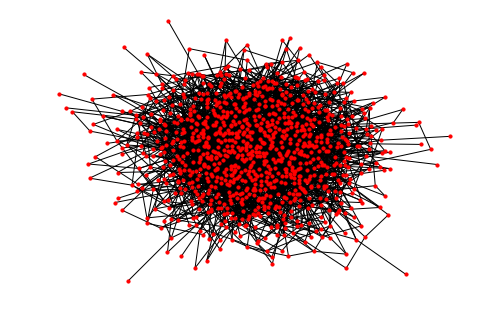

*** Network: NetA_rm10deg ***
isConnected = True
# connected components = 1


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


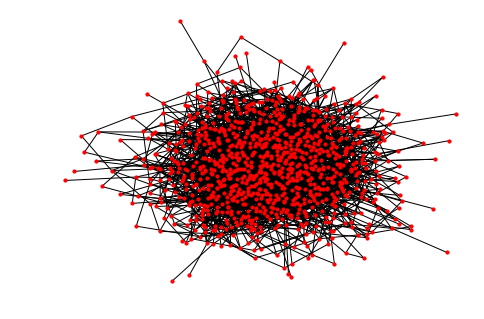

*** Network: NetA_rm10bet ***
isConnected = True
# connected components = 1


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


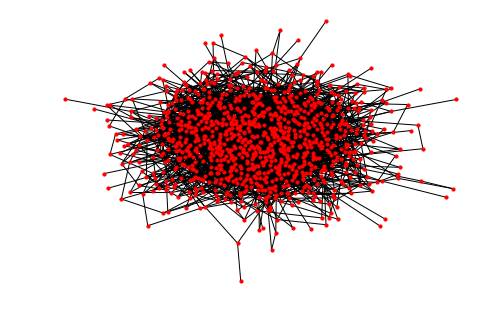

*** Network: NetA_rm5deg5bet ***
isConnected = True
# connected components = 1


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


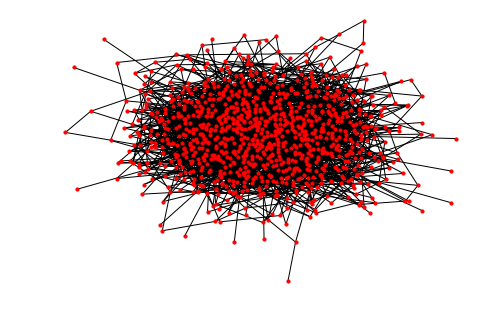

In [13]:
for n,name in zip(net_list, net_list_name):
    print("*** Network:", name, "***")
    print("isConnected =", nx.is_connected(n))
    print("# connected components =", nx.number_connected_components(n))
    nx.draw(n, node_size=10)
    plt.show()

In [17]:
# Network B
net_list = [NetB]

NetB_copy = NetB.copy()

for i in range(10):
    node_deg = NetB_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetB_copy.remove_node(np.argmax(Net_degree))
    
net_list.append(NetB_copy)

NetB_copy = NetB.copy()

for i in range(10):
    node_bet = list(nx.betweenness_centrality(NetB_copy).values())
    NetB_copy.remove_node(np.argmax(node_bet))
    
net_list.append(NetB_copy)

NetB_copy = NetB.copy()

for i in range(5):
    node_deg = NetB_copy.degree()
    node_deg = list(node_deg)
    Net_degree = np.array([x[1] for x in node_deg])
    NetB_copy.remove_node(np.argmax(Net_degree))
for i in range(5):
    node_bet = list(nx.betweenness_centrality(NetB_copy).values())
    NetB_copy.remove_node(np.argmax(node_bet))

net_list.append(NetB_copy)

net_list_name = ["NetB", "NetB_rm10deg", "NetB_rm10bet", "NetB_rm5deg5bet"]

for n,name in zip(net_list, net_list_name):
    os.makedirs(name+"/iterations/")
    print("##### NET:", name, "#####")
    Gillespie(net=n, netName=name)


##### NET: NetB_rm10deg #####
***lambda = 0.05


D:\Miniconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


***lambda = 0.06938775510204082


KeyboardInterrupt: 

*** Network: NetB ***
isConnected = True
# connected components = 1


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


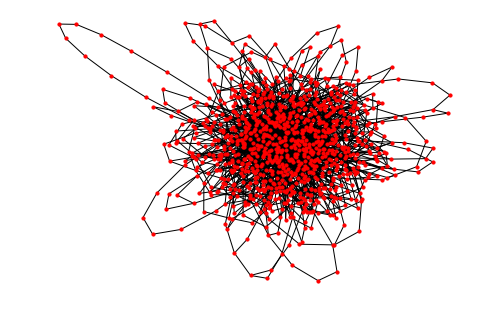

*** Network: NetB_rm10deg ***
isConnected = False
# connected components = 2


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


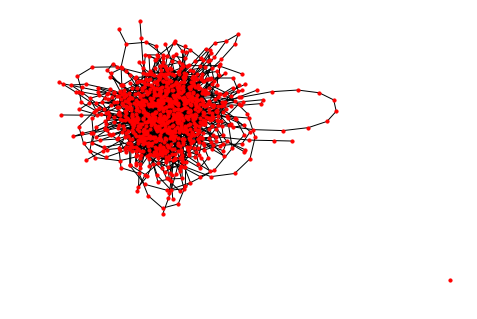

*** Network: NetB_rm10bet ***
isConnected = True
# connected components = 1


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


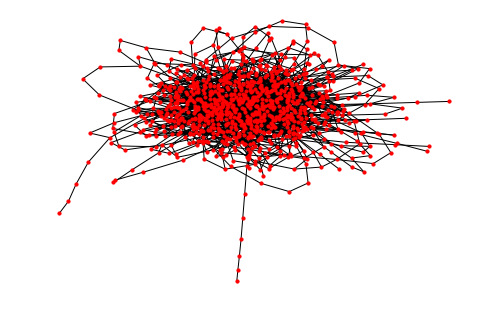

*** Network: NetB_rm5deg5bet ***
isConnected = False
# connected components = 3


D:\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


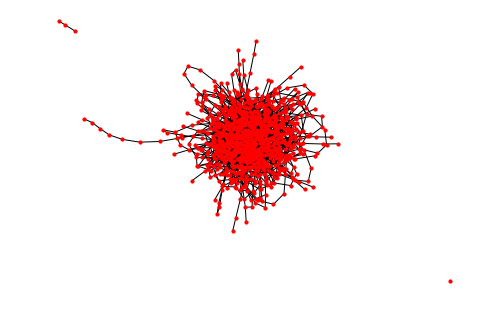

In [9]:
for n,name in zip(net_list, net_list_name):
    print("*** Network:", name, "***")
    print("isConnected =", nx.is_connected(n))
    print("# connected components =", nx.number_connected_components(n))
    nx.draw(n, node_size=10)
    plt.show()